In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


In [2]:
symbol = "ETHUSDT"
if not Path("Users").exists():  # Windows
    input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500\VPIN"
    file_path = rf"{input_path}\{symbol}.csv"
else:  # Macbook
    input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500/VPIN"
    file_path = f"{input_path}/{symbol}.csv"

df = pd.read_csv(file_path, parse_dates=['Time'])

df = df.drop(columns=["Unnamed: 0"], errors='ignore')

In [3]:
lst_input = ["VPIN", "Roll", "RollImpact", "KyleLambda", "AmihudLambda"]
list_output = ["SpreadChangeSign", "RealizedVolatilitySign", "JB_ChangeSign", "AR_ChangeSign", "SkewnessSign", "KurtosisSign", "ReturnsSign", "MASign"]

# Khảo sát bộ data

In [4]:
# Chỉ giữ lại các cột cần dùng
df = df[lst_input + list_output]

In [5]:
df.shape

(223, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VPIN                    174 non-null    float64
 1   Roll                    172 non-null    float64
 2   RollImpact              172 non-null    float64
 3   KyleLambda              173 non-null    float64
 4   AmihudLambda            173 non-null    float64
 5   SpreadChangeSign        173 non-null    float64
 6   RealizedVolatilitySign  123 non-null    float64
 7   JB_ChangeSign           123 non-null    float64
 8   AR_ChangeSign           123 non-null    float64
 9   SkewnessSign            123 non-null    float64
 10  KurtosisSign            123 non-null    float64
 11  ReturnsSign             172 non-null    float64
 12  MASign                  223 non-null    int64  
dtypes: float64(12), int64(1)
memory usage: 22.8 KB


- Bộ dữ liệu có những dòng dữ liệu null do quá trình tính toán bằng rolling

In [7]:
# Xóa những dòng có giá trị null
df = df.dropna()
df.shape

(123, 13)

# PHÂN TÍCH BIẾN ĐẦU VÀO

### Thống kê mô tả của các biến đầu vào cho mô hình

In [8]:
pd.DataFrame(df[lst_input].describe()).T

,count,mean,std,min,25%,50%,75%,max
VPIN,123.0,1.814156e-01,1.785302e-02,1.404208e-01,1.706410e-01,1.840882e-01,1.955003e-01,2.118973e-01
Roll,123.0,7.760623e+00,3.549102e+00,4.954786e-01,4.476305e+00,9.192014e+00,1.074541e+01,1.309427e+01
RollImpact,123.0,2.139676e-07,9.772280e-08,1.357542e-08,1.237609e-07,2.563201e-07,2.971673e-07,3.560983e-07
KyleLambda,123.0,6.419523e+10,2.964172e+11,-1.807119e+11,-1.862850e-03,-1.522447e-03,-1.172218e-03,2.345284e+12
AmihudLambda,123.0,7.210086e+06,5.046573e+05,6.272754e+06,6.835537e+06,7.211659e+06,7.483563e+06,8.410730e+06


### Biểu đồ phân bố của VPIN

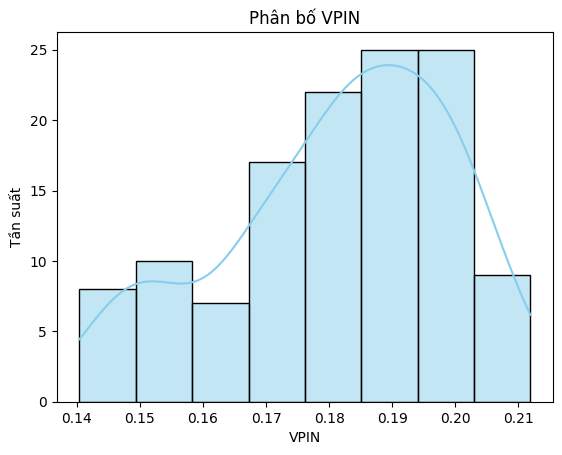

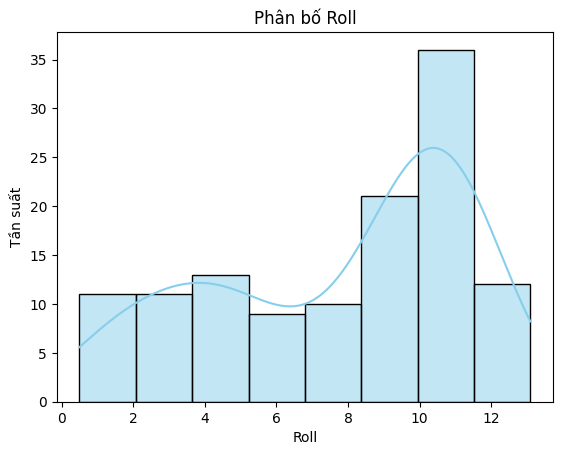

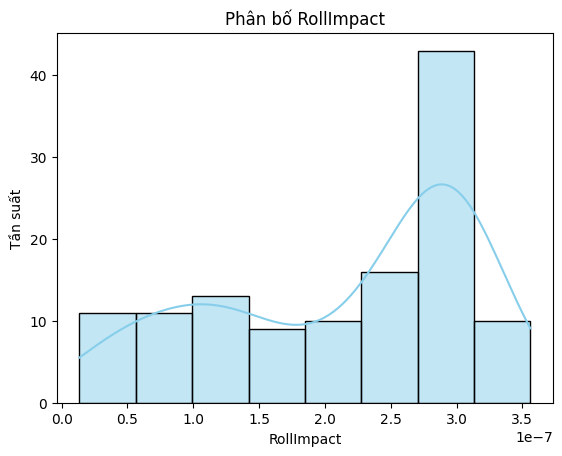

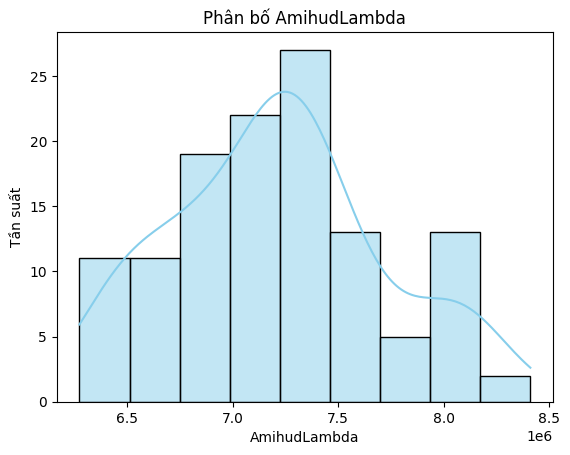

In [9]:
for col in lst_input:
    try:
        plt.Figure(figsize=(10, 6))
        sns.histplot(df[col], kde=True, color='skyblue')
        plt.title(f'Phân bố {col}')
        plt.xlabel(col)
        plt.ylabel('Tần suất')
        plt.show()
    except:
        pass

### Vẽ biểu đồ hộp - Boxplot của VPIN

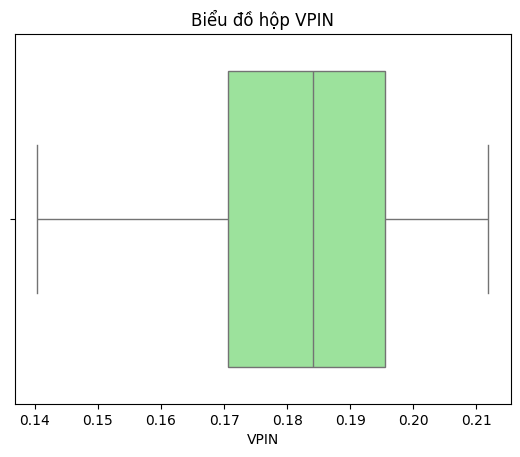

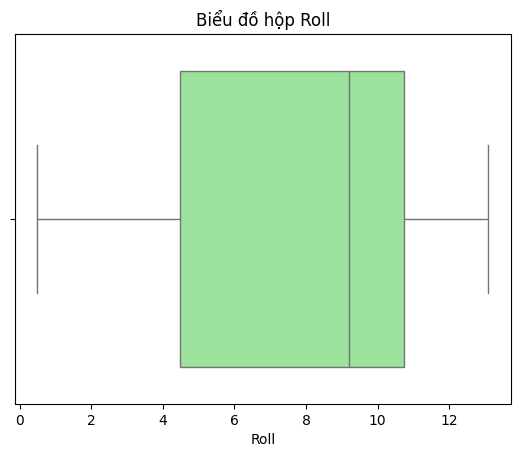

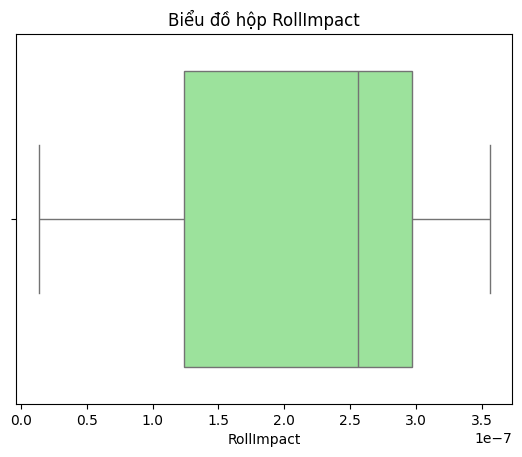

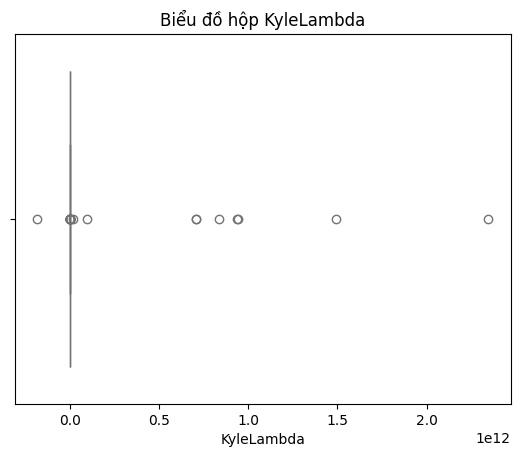

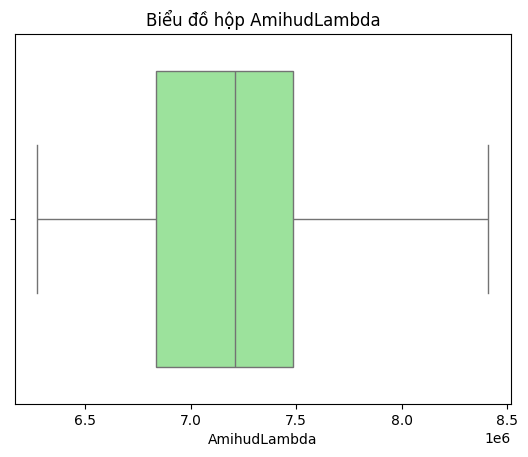

In [10]:
for col in lst_input:
    plt.Figure(figsize=(10, 6))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Biểu đồ hộp {col}')
    plt.xlabel(col)
    plt.show()

In [11]:
# def plot_vpin(buckets, col):
#     plt.figure(figsize=(12,6))
#     plt.plot(buckets["Time"].dt.floor('h'), buckets[col], label=f'{col}', linewidth=1.5)
#     plt.title(f"Xu hướng {col} the thời gian")
#     plt.xlabel("Thời gian")
#     plt.ylabel(col)
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.xticks(rotation=30)
#     plt.show()
# plot_vpin(df, "VPIN")


In [12]:
df[lst_input].corr()

,VPIN,Roll,RollImpact,KyleLambda,AmihudLambda
VPIN,1.000000,0.085738,0.062688,0.120863,-0.098834
Roll,0.085738,1.000000,0.999035,0.034553,-0.688584
RollImpact,0.062688,0.999035,1.000000,0.031548,-0.680368
KyleLambda,0.120863,0.034553,0.031548,1.000000,-0.062968
AmihudLambda,-0.098834,-0.688584,-0.680368,-0.062968,1.000000


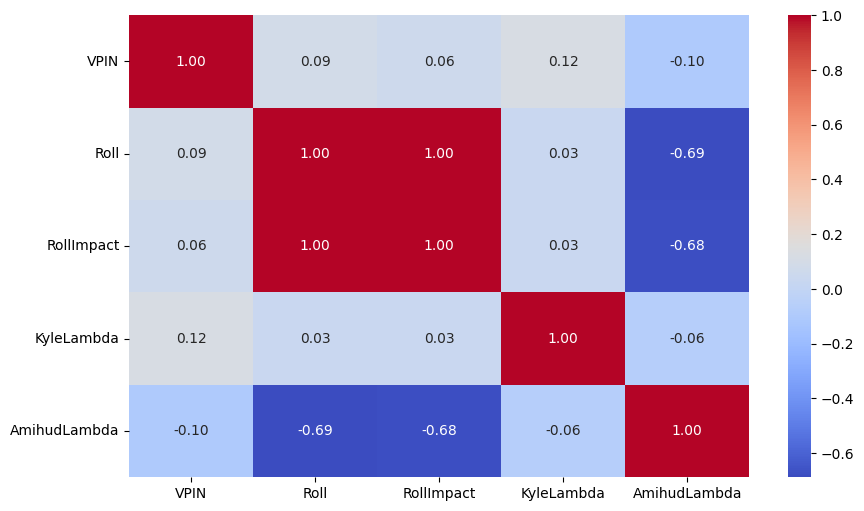

In [13]:
# heatmap:
plt.figure(figsize=(10, 6))
sns.heatmap(df[lst_input].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

<Figure size 1000x600 with 0 Axes>

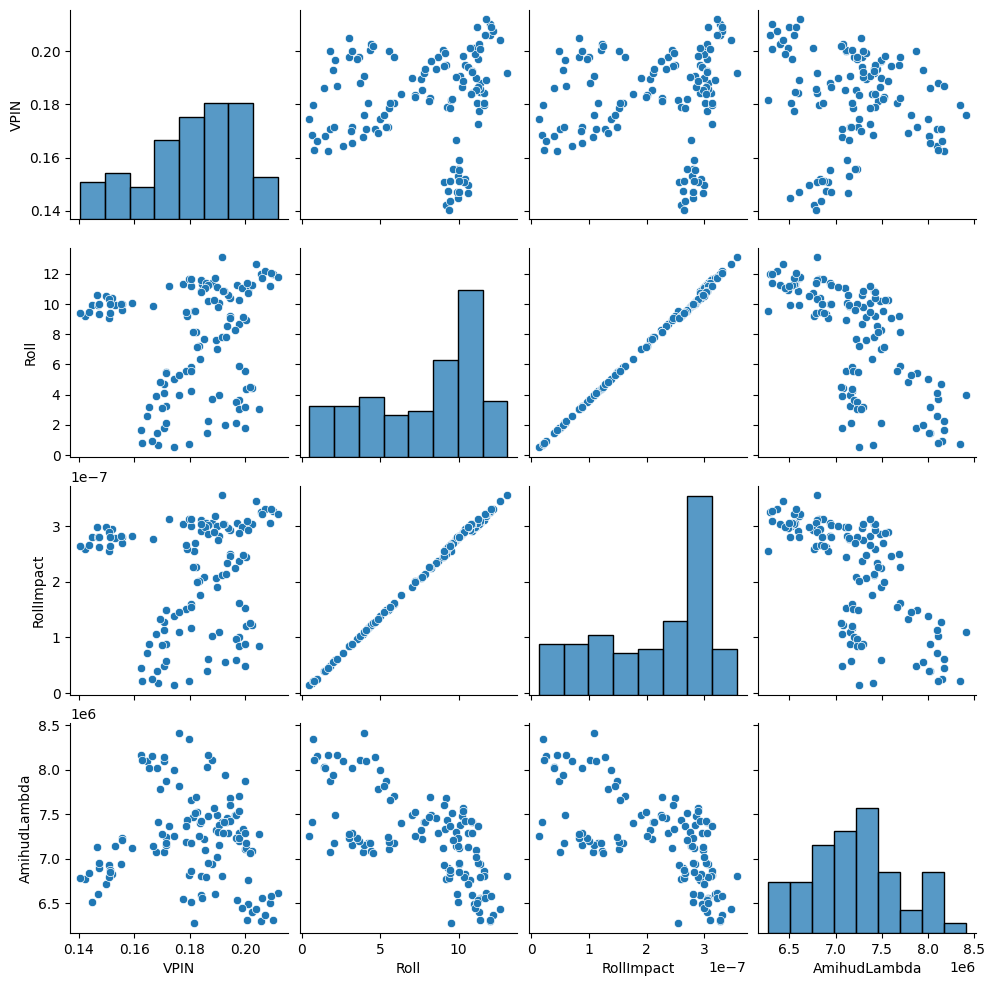

In [14]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.pairplot(df[['VPIN', 'Roll', 'RollImpact', 'AmihudLambda']])
plt.show()

# Phân tích mối quan hệ giữa VPIN và các biến mục tiêu

In [15]:
# List các biến mục tiêu
target_cols = list_output

In [16]:
# Loại bỏ các dữ liệu Nan do việc tính toán các chỉ số thống kê cuộn
df = df.dropna(subset=target_cols + ['VPIN'])

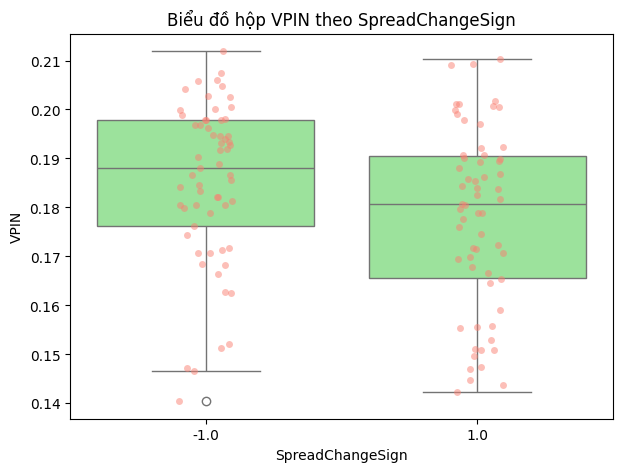

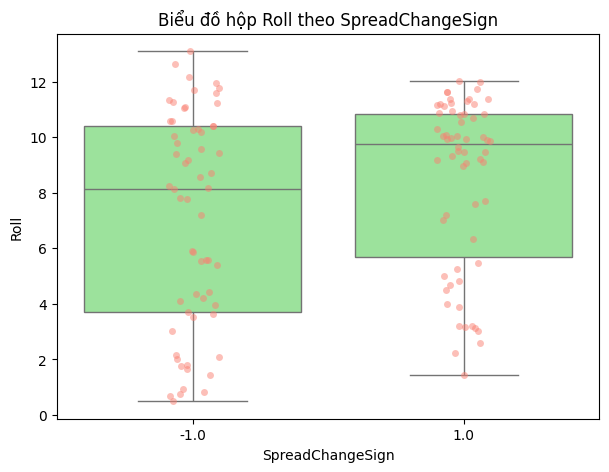

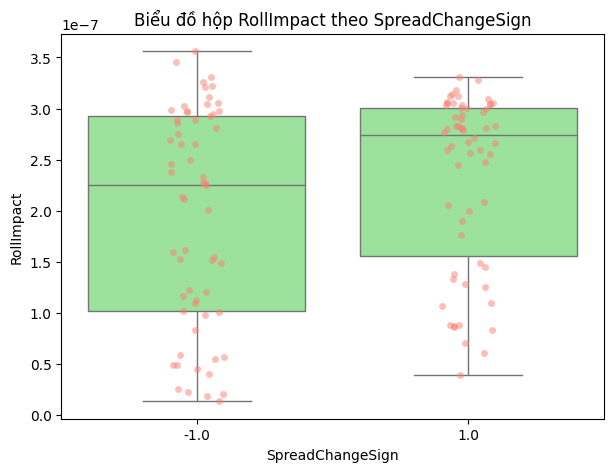

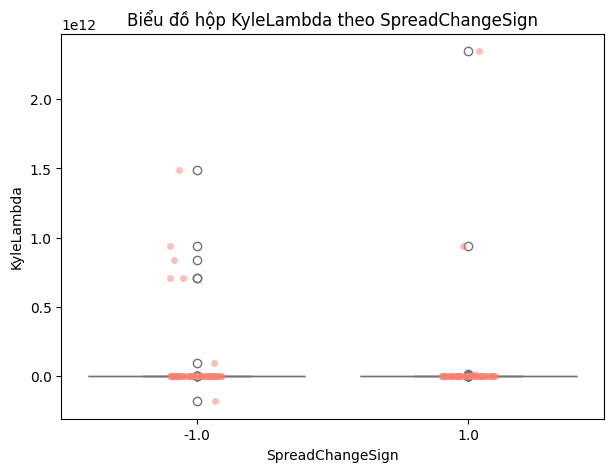

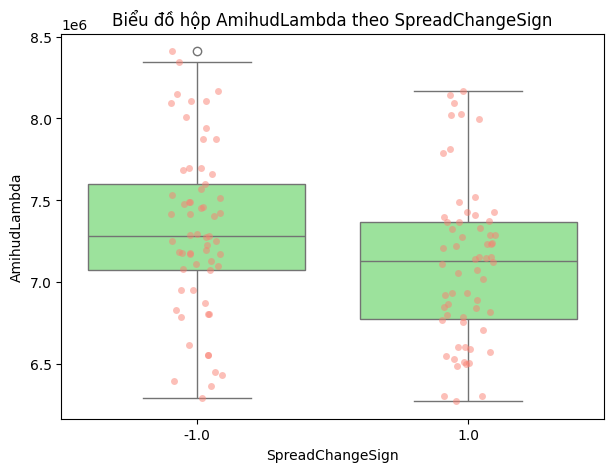

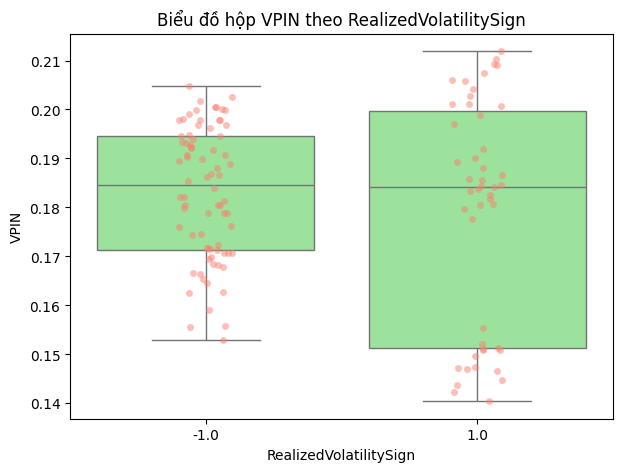

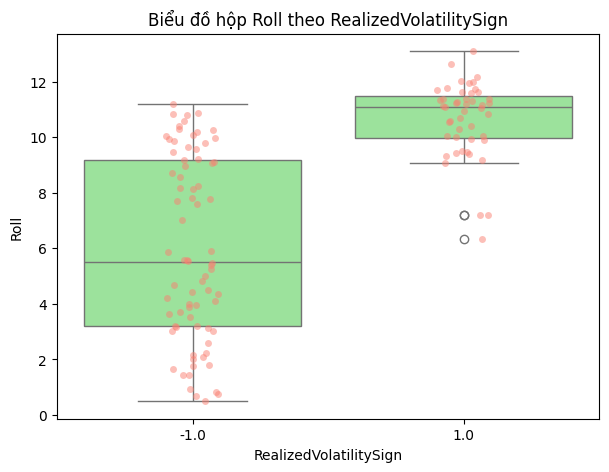

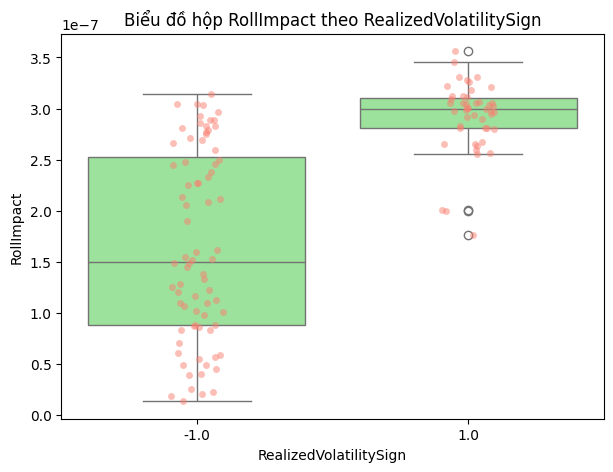

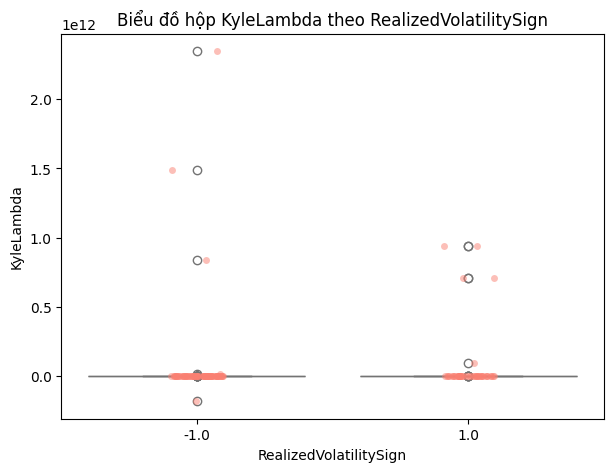

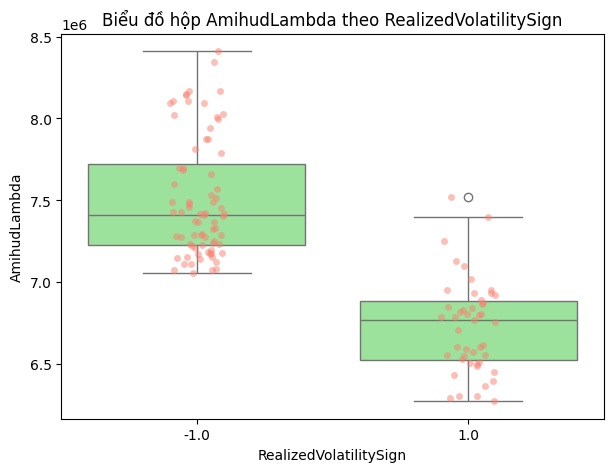

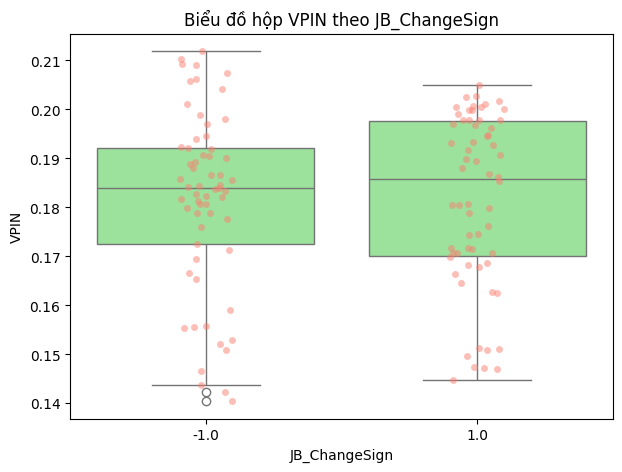

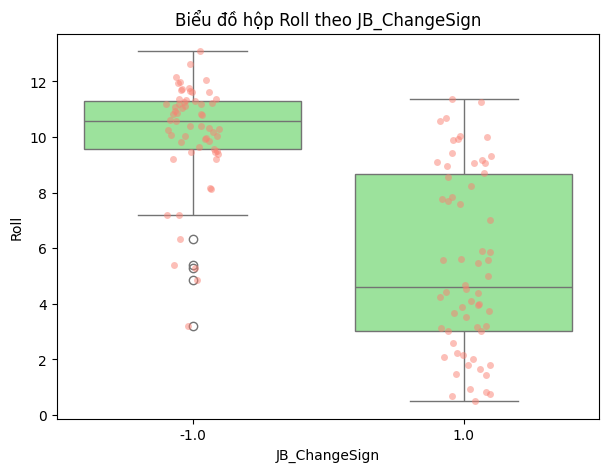

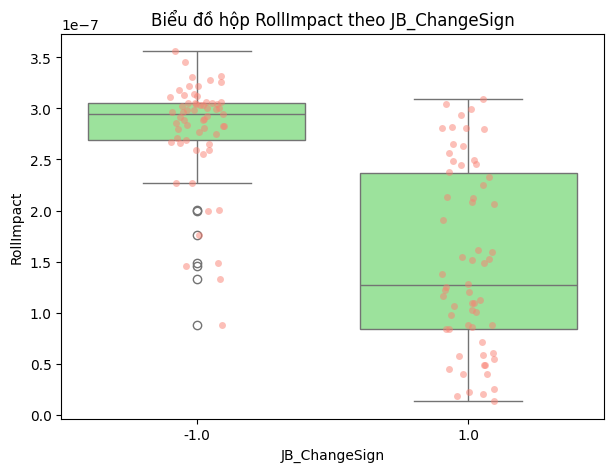

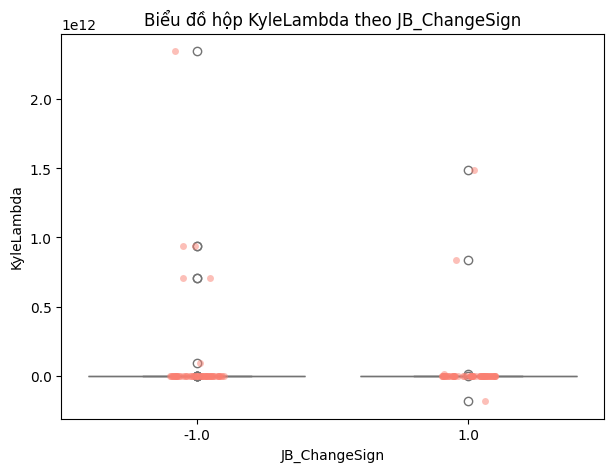

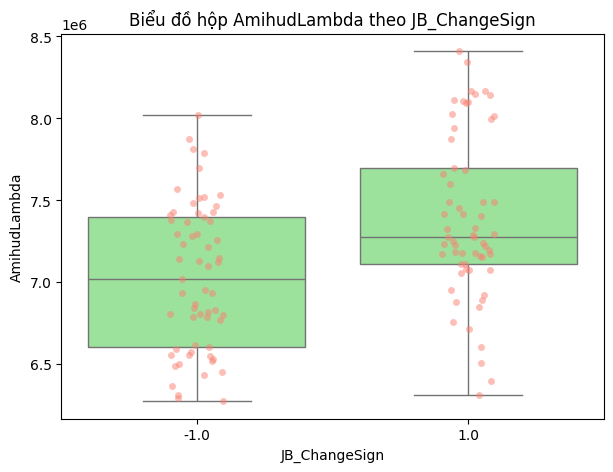

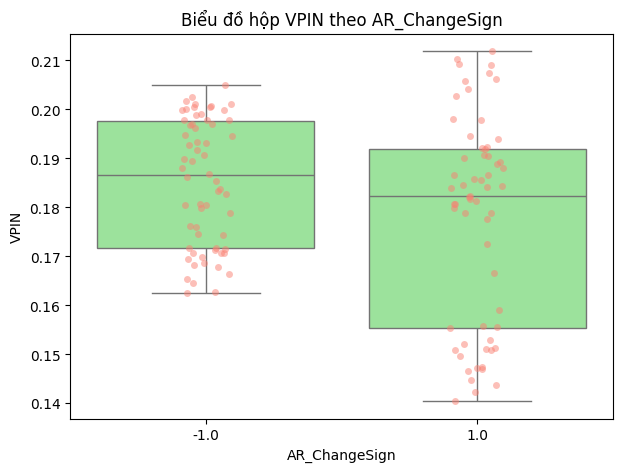

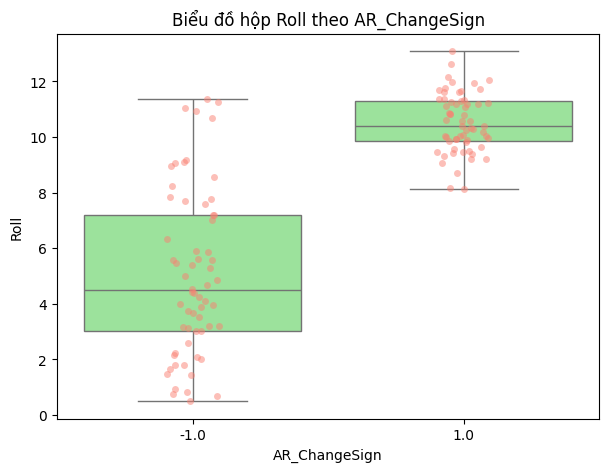

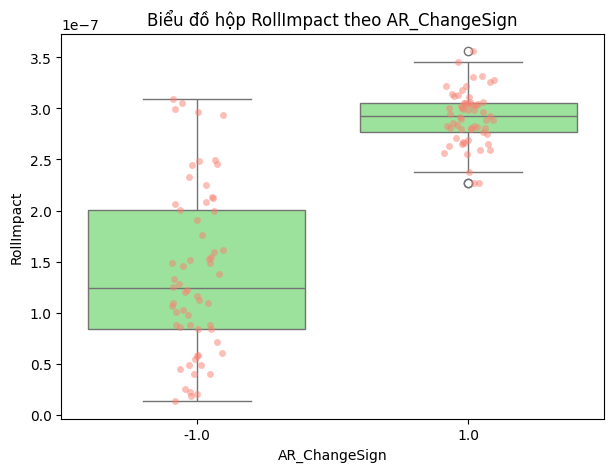

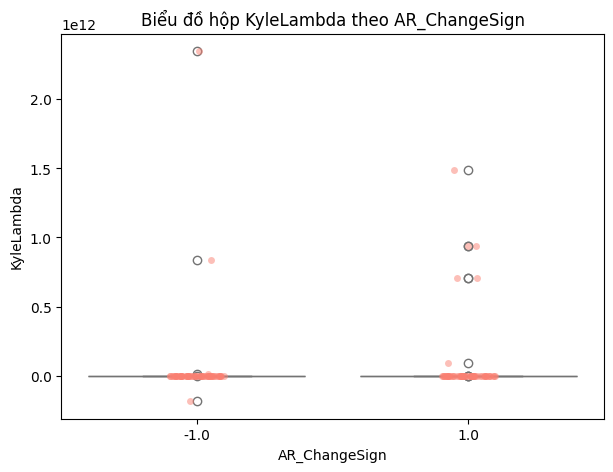

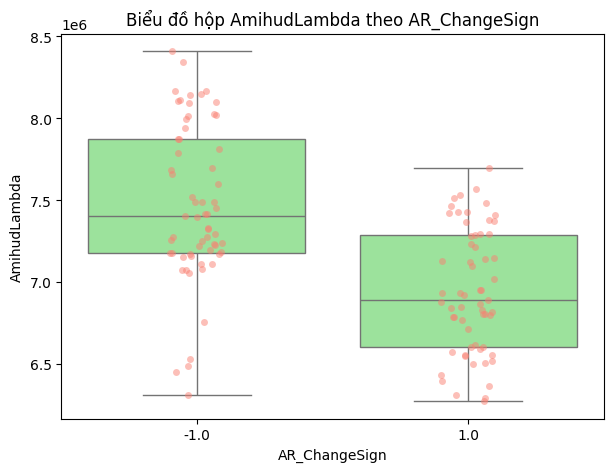

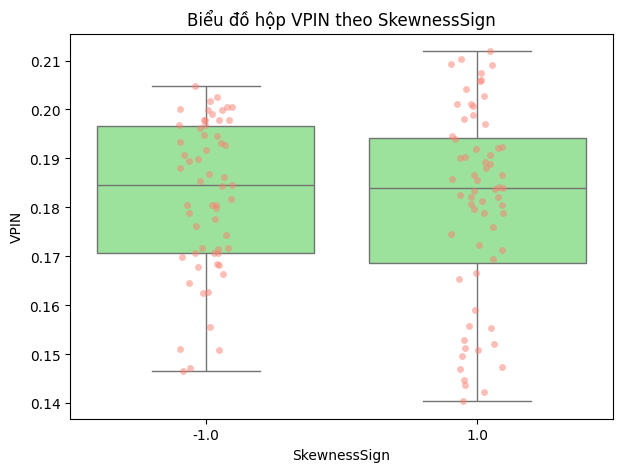

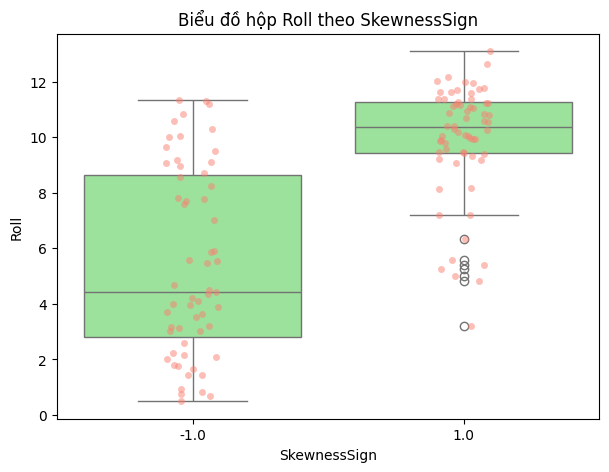

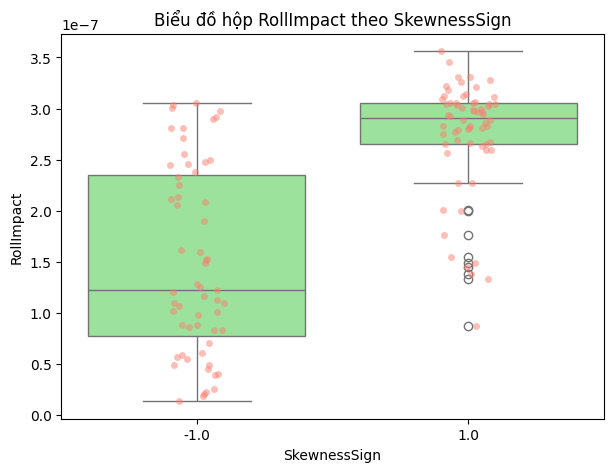

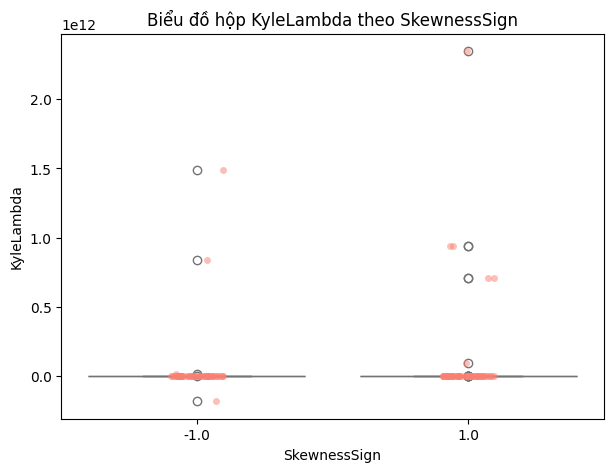

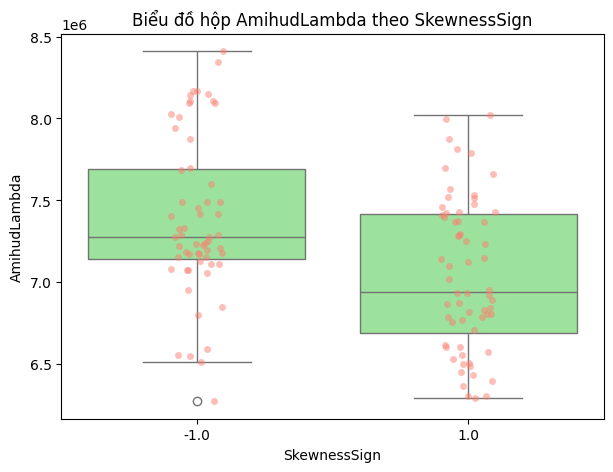

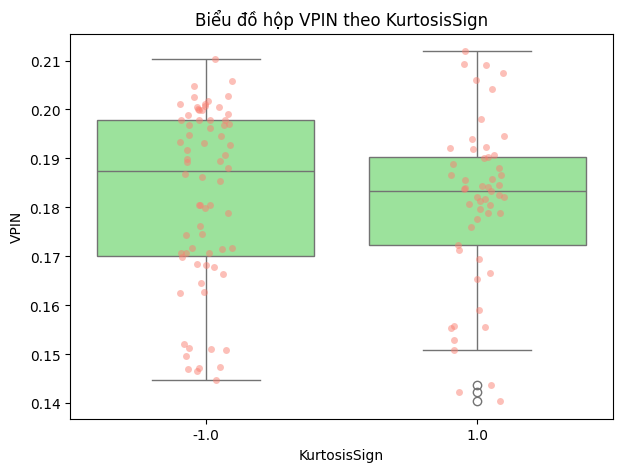

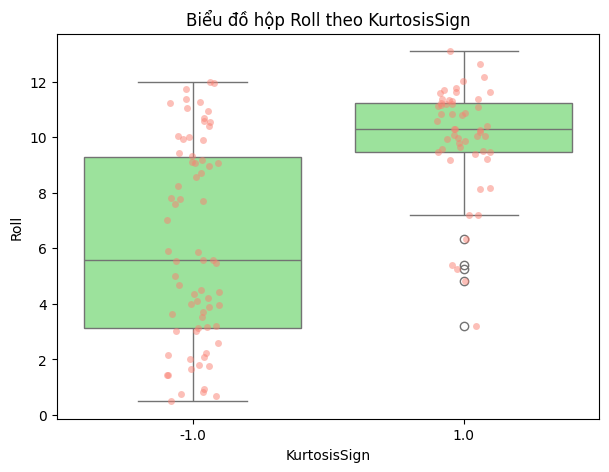

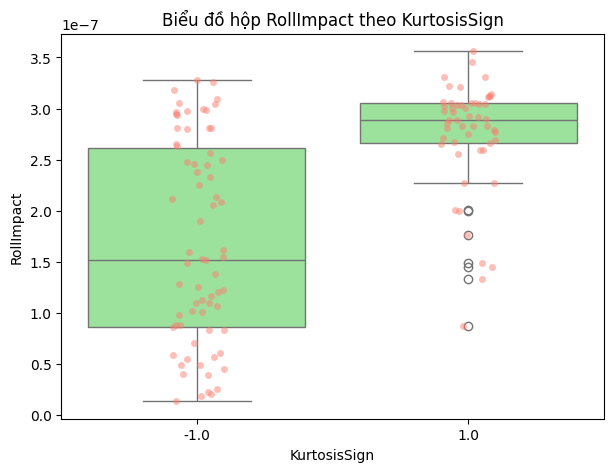

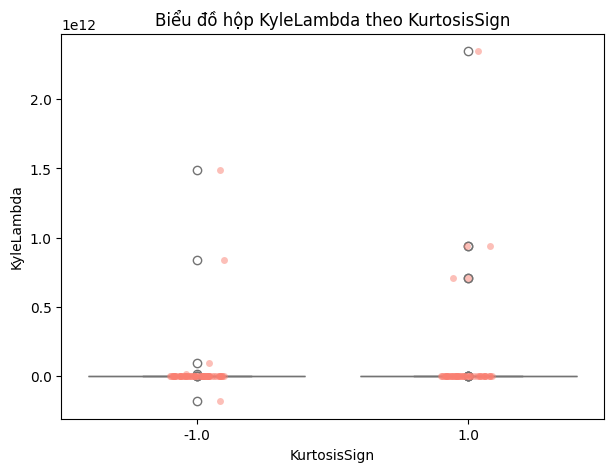

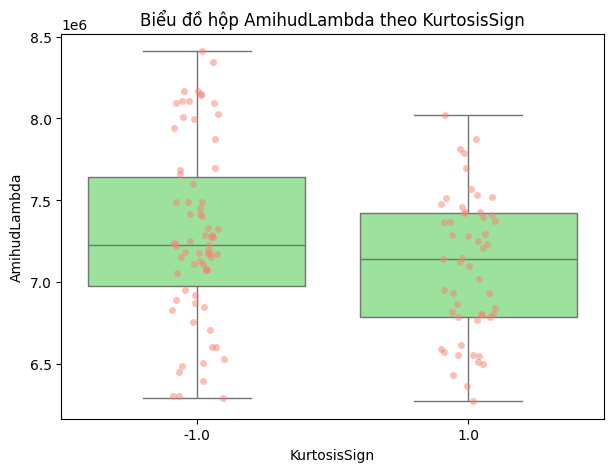

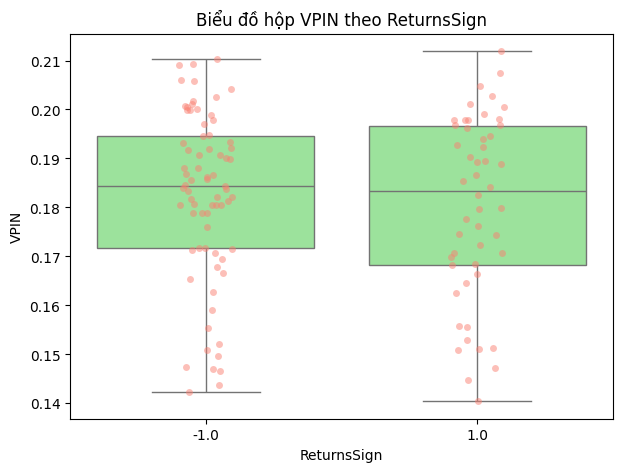

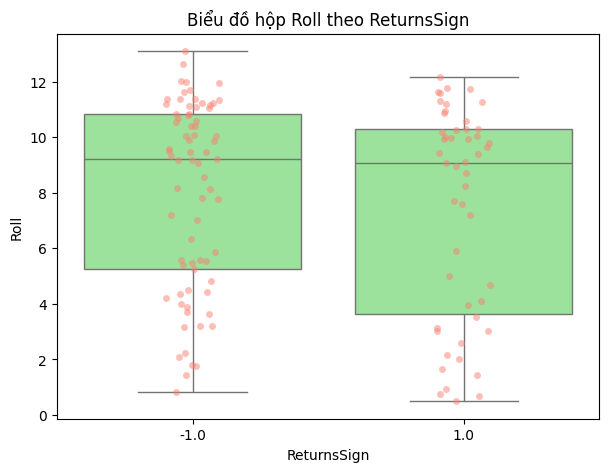

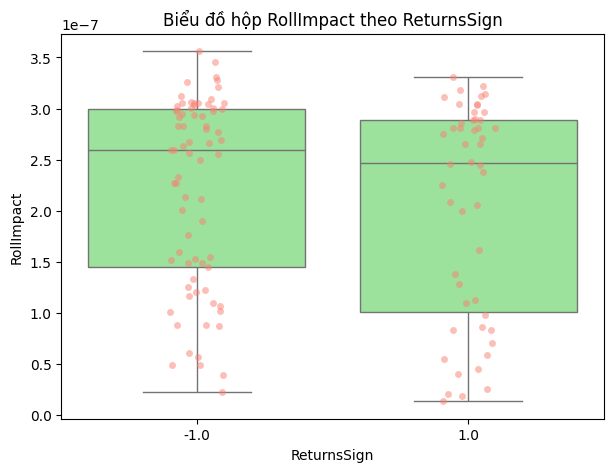

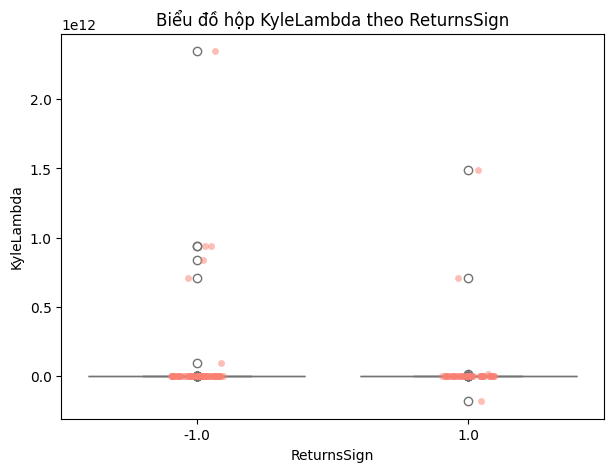

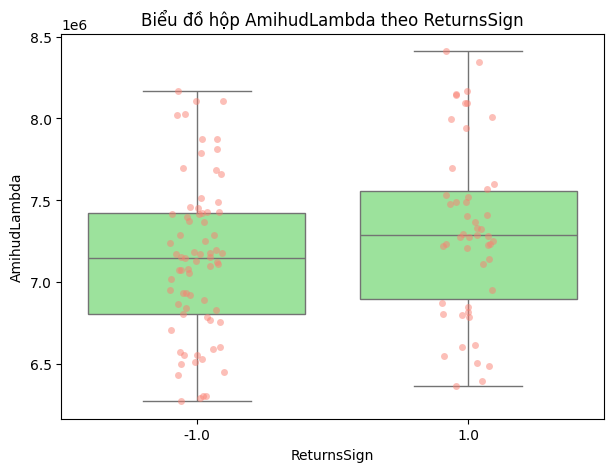

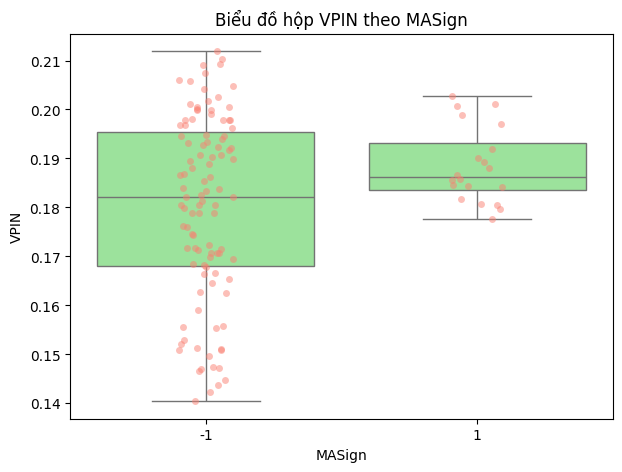

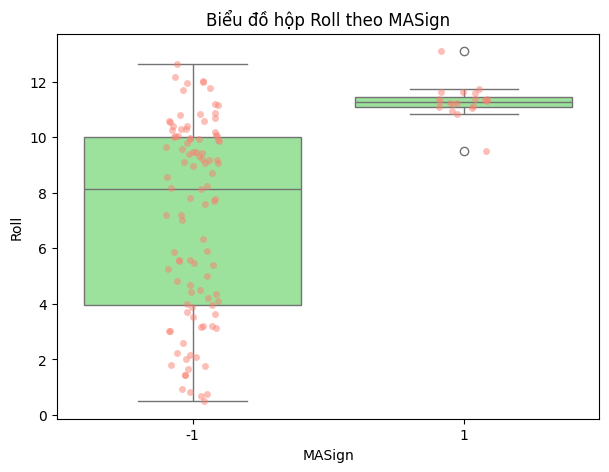

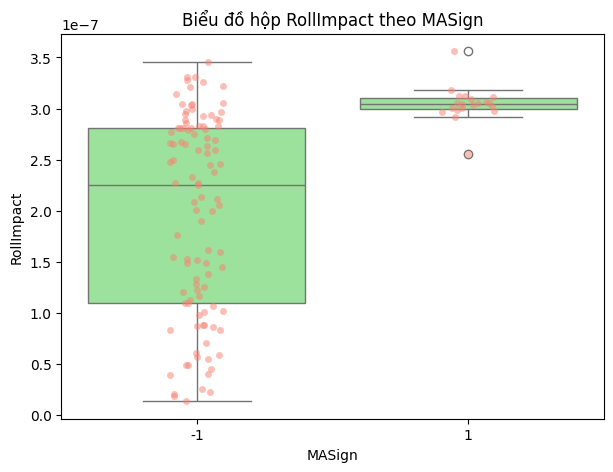

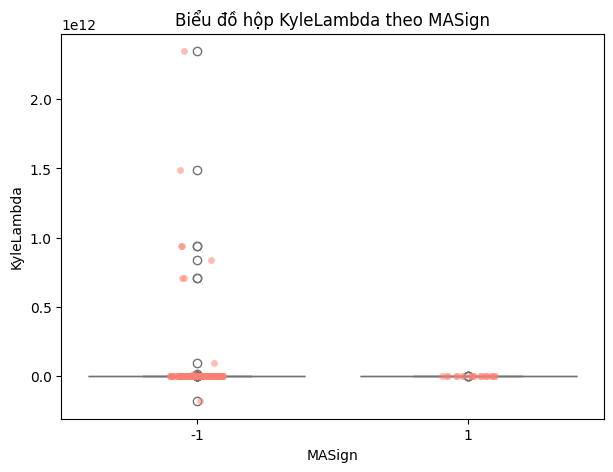

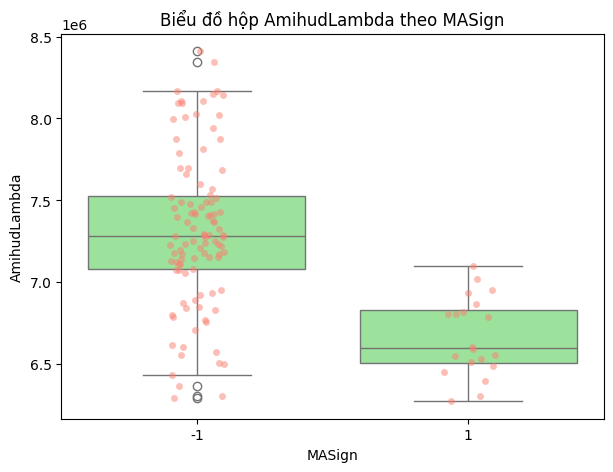

In [17]:
for col in target_cols:
    for col_in in lst_input:
        plt.figure(figsize=(7, 5))
        sns.boxplot(x=col, y=col_in, data=df, color='lightgreen')
        sns.stripplot(x=col, y=col_in, data=df, color='salmon', alpha=0.5, jitter=True)
        plt.title(f'Biểu đồ hộp {col_in} theo {col}')
        plt.show()

In [18]:
# for col in target_cols:
#     plt.figure(figsize=(6, 2))
#     sns.barplot(x=col, y='VPIN', data=df, color='lightgreen', errorbar=('ci', 95))
#     plt.title(f'Trung bình VPIN theo {col}')
#     plt.show()

# Kiểm định

### Kiểm tra phân phối của dữ liệu của các biến đầu vào

- Giả thuyết H0: Dữ liệu từng biến đầu vào tuân theo phân phối chuẩn
- Giả thuyết H1: Dữ liệu từng biến đầu không tuân theo phân phối chuẩn.

In [19]:
pvalue_normal_df = pd.DataFrame(index=lst_input, columns=["pvalue"])
for col in lst_input:
    stat, p = shapiro(df[col].dropna())
    # print(f'Shapiro-Wilk test: p-value = {p}')
    pvalue_normal_df.loc[col, "pvalue"] = p
pvalue_normal_df

,pvalue
VPIN,0.00028
Roll,0.0
RollImpact,0.0
KyleLambda,0.0
AmihudLambda,0.027065


Với mức ý nghĩa 5%:
- p rất bé => Bác bỏ giả thuyết H0. Chưa đủ bằng chứng để kết luận rằng dữ liệu của từng biến đầu vào có phân phối chuẩn

### Kiểm tra phân phối của các cột đầu vào theo từng nhóm

- Giả thuyết H0: Dữ liệu từng biến đầu vào cho từng nhóm có phân phối chuẩn
- Giả thuyế H1: Dữ liệu từng biến đầu cho từng nhóm không có phân phối chuẩn

In [20]:

pvalue_normal_1 = pd.DataFrame(index=target_cols, columns=lst_input)
pvalue_normal_minus1 = pd.DataFrame(index=target_cols, columns=lst_input)

for col in target_cols:
    for col_in in lst_input:
        # print(f"Kiểm định cho giá trị {col} - {col_in}")
        gr1 = df.loc[df[col] == 1, col_in]
        p1 = shapiro(gr1)[1]
        gr2 = df.loc[df[col] == -1, col_in]
        p2 = shapiro(gr1)[1]
        # print(f"pvalue với {col} = 1 cho {col_in}: ", p1)
        # print(f"pvalue với {col} = -1 cho {col_in}: ", p2)
        
        pvalue_normal_1.loc[col, col_in] = p1
        pvalue_normal_minus1.loc[col, col_in] = p2
pvalue_normal_1, pvalue_normal_minus1



(                            VPIN      Roll RollImpact KyleLambda AmihudLambda
 SpreadChangeSign        0.037109  0.000003   0.000001        0.0     0.045102
 RealizedVolatilitySign  0.000282  0.001117   0.000224        0.0     0.112091
 JB_ChangeSign           0.000284  0.002629   0.002391        0.0     0.031347
 AR_ChangeSign           0.000625  0.811435   0.764209        0.0     0.065804
 SkewnessSign            0.003405  0.000004        0.0        0.0     0.063534
 KurtosisSign            0.017918  0.000025   0.000002        0.0     0.246067
 ReturnsSign             0.037358  0.000053   0.000027        0.0     0.116157
 MASign                  0.081861  0.000811   0.000514   0.083504     0.516776,
                             VPIN      Roll RollImpact KyleLambda AmihudLambda
 SpreadChangeSign        0.037109  0.000003   0.000001        0.0     0.045102
 RealizedVolatilitySign  0.000282  0.001117   0.000224        0.0     0.112091
 JB_ChangeSign           0.000284  0.002629   0.002

- Bác bỏ giả thuyết H0 rằng data cho từng nhóm có phân phối chuẩn

- Dữ liệu của các cột input và dữ liệu của chúng theo từng nhóm đều không có phân phối chuẩn, ta dùng kiểm định mannwhitneyu để kiểm định xem  giá trị input có khác biệt giữa các nhóm phân loại hay không

### Kiểm định Mannwhitney U
- Giả thuyết không (H₀): Phân phối của hai nhóm là giống nhau (không có sự khác biệt về vị trí trung tâm).

- Giả thuyết đối (H₁): Phân phối của hai nhóm là khác nhau (có sự khác biệt về vị trí trung tâm).

In [21]:
pvalue_df = pd.DataFrame(index=target_cols, columns=lst_input)
for col in target_cols:
    for col_in in lst_input:
        gr1 = df.loc[df[col] == 1, col_in]
        gr2 = df.loc[df[col] == -1, col_in]
        stat, p = mannwhitneyu(gr1, gr2)
        pvalue_df.loc[col, col_in] = p
pvalue_df

,VPIN,Roll,RollImpact,KyleLambda,AmihudLambda
SpreadChangeSign,0.025528,0.051777,0.047095,0.853516,0.015286
RealizedVolatilitySign,0.713652,0.0,0.0,0.126592,0.0
JB_ChangeSign,0.961672,0.0,0.0,0.330178,0.000426
AR_ChangeSign,0.085915,0.0,0.0,0.053007,0.0
SkewnessSign,0.881283,0.0,0.0,0.889278,0.000582
KurtosisSign,0.427086,0.0,0.0,0.741837,0.084758
ReturnsSign,0.58343,0.319077,0.321585,0.36617,0.041188
MASign,0.100685,0.0,0.0,0.356598,0.0


- VPIN: phân biệt rõ các biến liên quan JB_ChangeSign và KurtosisSign.
- Roll & RollImpact: dự đoán tốt RealizedVolatilitySign, AR_ChangeSign, SkewnessSign, MASign.
- KyleLambda & AmihudLambda: nhạy với RealizedVolatilitySign, AR_ChangeSign, SkewnessSign.
#### Kết luận:
- Roll, RollImpact, Kyle, Amihud là predictors mạnh cho nhiều biến Sign khác nhau.
- VPIN lại đặc biệt nhạy với các biến mô tả phân phối (JB, Kurtosis).
- ReturnsSign và SpreadChangeSign gần như không được phân biệt bởi các metric này.

## Áp dụng model: RandomForest

### Chuẩn bị bộ dữ liệu

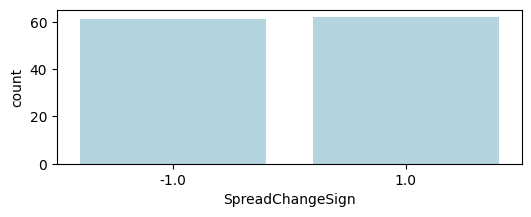

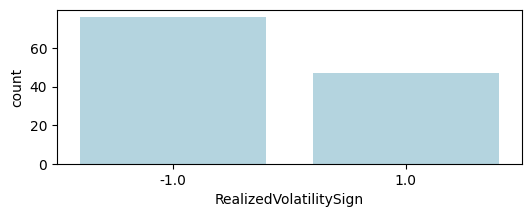

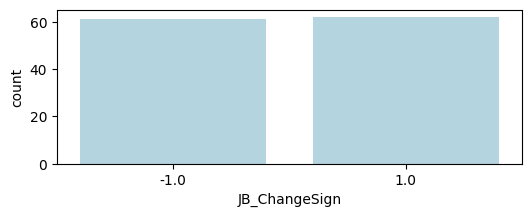

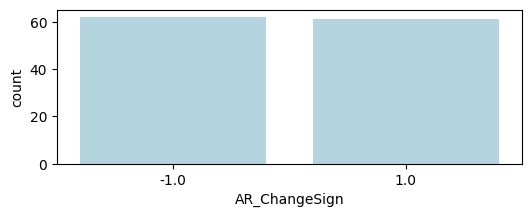

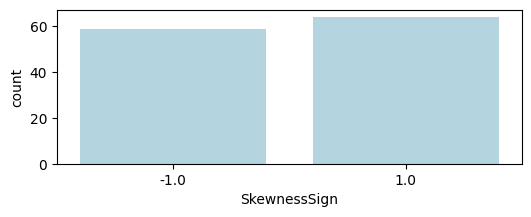

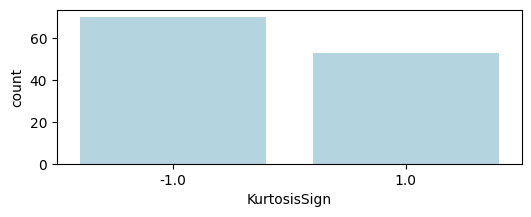

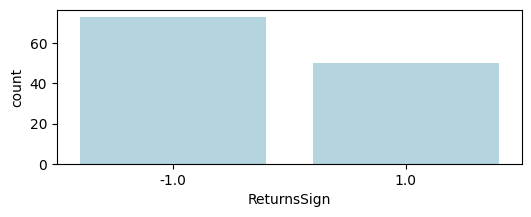

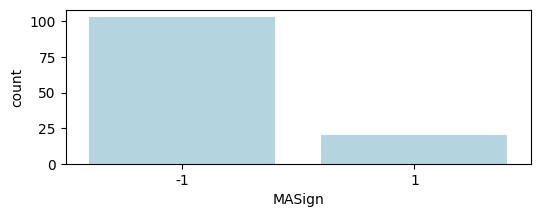

In [22]:
for col in target_cols:
    _ = pd.DataFrame(df[col].value_counts())
    plt.figure(figsize=(6, 2))
    sns.barplot(x=_.index, y=_["count"], color='lightblue', errorbar=('ci', 95))
    # plt.title(f'{col}')
    plt.show()

- Bộ dữ liệu có sự phân bố nhãn khá cân bằng giữa hai chiều giá trị (-1.0 và 1.0) ở các biến mục tiê. Mỗi biến đều có số lượng mẫu gần như tương đương giữa hai nhãn, với chênh lệch không đáng kể (dao động trong khoảng 2–14 mẫu). Điều này cho thấy bộ dữ liệu phù hợp để huấn luyện các mô hình học máy mà không cần xử lý mất cân bằng nhãn quá phức tạp.

In [23]:
train_data, test_data = {}, {}
for col in target_cols:
    data = df.copy()
    train_data[col], test_data[col] = train_test_split(data, test_size=0.3, random_state=42, stratify=data[col])
    

## Chỉ dùng VPIN làm biến đầu vào

In [24]:
train_cols = ["VPIN"]
acc_df = pd.DataFrame(index=target_cols, columns=["Accuracy"])
model_info = {}
for col in list_output:
    X_train = train_data[col][train_cols]
    y_train = train_data[col][col]
    X_test = test_data[col][train_cols]
    y_test = test_data[col][col]

    model_info[col] = RandomForestClassifier(n_estimators=1000, random_state=42)

    model_info[col].fit(X_train, y_train)

    y_pred = model_info[col].predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    acc_df.loc[col, "Accuracy"] = f"{accuracy:.4f}"
acc_df

Độ chính xác của mô hình cho SpreadChangeSign: 0.4595
              precision    recall  f1-score   support

        -1.0       0.43      0.33      0.38        18
         1.0       0.48      0.58      0.52        19

    accuracy                           0.46        37
   macro avg       0.45      0.46      0.45        37
weighted avg       0.45      0.46      0.45        37

Độ chính xác của mô hình cho RealizedVolatilitySign: 0.6757
              precision    recall  f1-score   support

        -1.0       0.74      0.74      0.74        23
         1.0       0.57      0.57      0.57        14

    accuracy                           0.68        37
   macro avg       0.66      0.66      0.66        37
weighted avg       0.68      0.68      0.68        37

Độ chính xác của mô hình cho JB_ChangeSign: 0.5405
              precision    recall  f1-score   support

        -1.0       0.53      0.50      0.51        18
         1.0       0.55      0.58      0.56        19

    accuracy     

,Accuracy
SpreadChangeSign,0.4595
RealizedVolatilitySign,0.6757
JB_ChangeSign,0.5405
AR_ChangeSign,0.7027
SkewnessSign,0.6486
KurtosisSign,0.6216
ReturnsSign,0.4324
MASign,0.7568


## Dùng tất cả các biến input

In [25]:
train_cols = lst_input
acc_df = pd.DataFrame(index=target_cols, columns=["Accuracy"])
model_info = {}
for col in list_output:
    X_train = train_data[col][train_cols]
    y_train = train_data[col][col]
    X_test = test_data[col][train_cols]
    y_test = test_data[col][col]

    model_info[col] = RandomForestClassifier(n_estimators=1000, random_state=42)

    model_info[col].fit(X_train, y_train)

    y_pred = model_info[col].predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    acc_df.loc[col, "Accuracy"] = f"{accuracy:.4f}"
print("Accuracy df:")
acc_df

Độ chính xác của mô hình cho SpreadChangeSign: 0.6216
              precision    recall  f1-score   support

        -1.0       0.61      0.61      0.61        18
         1.0       0.63      0.63      0.63        19

    accuracy                           0.62        37
   macro avg       0.62      0.62      0.62        37
weighted avg       0.62      0.62      0.62        37

Độ chính xác của mô hình cho RealizedVolatilitySign: 1.0000
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        23
         1.0       1.00      1.00      1.00        14

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

Độ chính xác của mô hình cho JB_ChangeSign: 0.9189
              precision    recall  f1-score   support

        -1.0       0.89      0.94      0.92        18
         1.0       0.94      0.89      0.92        19

    accuracy     

,Accuracy
SpreadChangeSign,0.6216
RealizedVolatilitySign,1.0000
JB_ChangeSign,0.9189
AR_ChangeSign,0.9189
SkewnessSign,0.9189
KurtosisSign,0.6486
ReturnsSign,0.6486
MASign,0.8919


### Mô hình XGBoost

In [26]:
train_cols = ["VPIN"]
for col in target_cols:
        # Khởi tạo mô hình XGBoost
    model = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        # use_label_encoder=False,
        eval_metric='logloss'
    )
    X_train = train_data[col][train_cols]
    y_train = train_data[col][col].map({-1.0: 0, 1.0: 1})
    X_test = test_data[col][train_cols]
    y_test = test_data[col][col].map({-1.0: 0, 1.0: 1})

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán và đánh giá
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
    print(report)


Độ chính xác của mô hình cho SpreadChangeSign: 0.4595
              precision    recall  f1-score   support

           0       0.43      0.33      0.38        18
           1       0.48      0.58      0.52        19

    accuracy                           0.46        37
   macro avg       0.45      0.46      0.45        37
weighted avg       0.45      0.46      0.45        37

Độ chính xác của mô hình cho RealizedVolatilitySign: 0.8378
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        23
           1       0.83      0.71      0.77        14

    accuracy                           0.84        37
   macro avg       0.84      0.81      0.82        37
weighted avg       0.84      0.84      0.83        37

Độ chính xác của mô hình cho JB_ChangeSign: 0.5405
              precision    recall  f1-score   support

           0       0.52      0.67      0.59        18
           1       0.57      0.42      0.48        19

    accuracy     

In [27]:
train_cols = lst_input
for col in target_cols:
        # Khởi tạo mô hình XGBoost
    model = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        # use_label_encoder=False,
        eval_metric='logloss'
    )
    X_train = train_data[col][train_cols]
    y_train = train_data[col][col].map({-1.0: 0, 1.0: 1})
    X_test = test_data[col][train_cols]
    y_test = test_data[col][col].map({-1.0: 0, 1.0: 1})

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán và đánh giá
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Độ chính xác của mô hình: {accuracy:.4f}")
    print(report)


Độ chính xác của mô hình: 0.5405
              precision    recall  f1-score   support

           0       0.54      0.39      0.45        18
           1       0.54      0.68      0.60        19

    accuracy                           0.54        37
   macro avg       0.54      0.54      0.53        37
weighted avg       0.54      0.54      0.53        37

Độ chính xác của mô hình: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        14

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

Độ chính xác của mô hình: 0.8919
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        18
           1       0.89      0.89      0.89        19

    accuracy                           0.89        37
   macro avg       0.89      